In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import pycocotools
from pycocotools import mask
import pycocotools.mask as mask_util
import numpy as np
import json
from pycocotools.coco import COCO
from sklearn.model_selection import train_test_split
import random
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import matplotlib as mpl
from tqdm import tqdm

def np_encoder(object):
    if isinstance(object, np.generic):
        return object.item()

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from matplotlib.colors import ListedColormap

In [ ]:
import os

os.chdir('/content/drive/MyDrive/srikaran')
os.getcwd()

'/content/drive/MyDrive/srikaran'

In [ ]:
os.makedirs('/content/datasets')

In [ ]:
import zipfile
import os

zip_path = '/content/drive/My Drive/srikaran/uw-madison-gi-tract-image-segmentation.zip'
extract_path = '/content/datasets'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Unzipped successfully!")

zip_path = '/content/drive/My Drive/srikaran/coco.zip'
extract_path = '/content/datasets'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Unzipped successfully!")

Unzipped successfully!
Unzipped successfully!


In [ ]:
!ls /content/datasets/train/case90/case90_day0/scans

slice_0001_266_266_1.50_1.50.png  slice_0073_266_266_1.50_1.50.png
slice_0002_266_266_1.50_1.50.png  slice_0074_266_266_1.50_1.50.png
slice_0003_266_266_1.50_1.50.png  slice_0075_266_266_1.50_1.50.png
slice_0004_266_266_1.50_1.50.png  slice_0076_266_266_1.50_1.50.png
slice_0005_266_266_1.50_1.50.png  slice_0077_266_266_1.50_1.50.png
slice_0006_266_266_1.50_1.50.png  slice_0078_266_266_1.50_1.50.png
slice_0007_266_266_1.50_1.50.png  slice_0079_266_266_1.50_1.50.png
slice_0008_266_266_1.50_1.50.png  slice_0080_266_266_1.50_1.50.png
slice_0009_266_266_1.50_1.50.png  slice_0081_266_266_1.50_1.50.png
slice_0010_266_266_1.50_1.50.png  slice_0082_266_266_1.50_1.50.png
slice_0011_266_266_1.50_1.50.png  slice_0083_266_266_1.50_1.50.png
slice_0012_266_266_1.50_1.50.png  slice_0084_266_266_1.50_1.50.png
slice_0013_266_266_1.50_1.50.png  slice_0085_266_266_1.50_1.50.png
slice_0014_266_266_1.50_1.50.png  slice_0086_266_266_1.50_1.50.png
slice_0015_266_266_1.50_1.50.png  slice_0087_266_266_1.50_1.50

In [ ]:
!pip install monai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 13.6 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylin

In [ ]:
os.chdir('/content/drive/My Drive/srikaran/gi-tract-image-segmentation')
os.getcwd()

'/content/drive/My Drive/srikaran/gi-tract-image-segmentation'

In [ ]:
from src.data import SegmentationDataset
from src.data import DataGenerator
from src.model import SimpleUNet
from src.loss import DiceLoss, ChannelwiseHausdorffDistanceLoss, CombinedLoss, IoU, AverageMeter
from src.utils.plot_utils import plot_masks, display_comparison
from monai.losses import DiceLoss

CLASSES = ['small_bowel', 'large_bowel', 'stomach']

In [ ]:
class IoU(nn.Module):
    def __init__(self):
        super(IoU, self).__init__()

    def forward(self, input, target):
        # Assumes input and target are of the same shape [batch_size, channels, height, width]
        batch_size = input.size(0)
        channels = input.size(1)
        iou_values_0 = []
        iou_values_1 = []
        iou_values_2 = []

        for i in range(batch_size):
            for ch in range(channels):
                input_flat = (input[i, ch] > 0.5).float()
                target_flat = (target[i, ch] > 0.5).float()

                if target_flat.sum() == 0:
                    continue

                if input_flat.sum() == 0 and target_flat.sum() == 0:
                    continue  # Skip channel if both input and target are all zeros

                intersection = (input_flat * target_flat).sum()
                union = (input_flat + target_flat).clamp(0, 1).sum()  # Use clamp to handle union calculation

                if union == 0:
                    iou = torch.tensor(0.)  # Avoid division by zero; can also return 1 if both masks are empty
                else:
                    iou = intersection / union

                # Append iou based on the channel
                if ch == 0:
                    iou_values_0.append(iou)
                elif ch == 1:
                    iou_values_1.append(iou)
                elif ch == 2:
                    iou_values_2.append(iou)

        # Calculate mean avoiding empty lists
        mean_iou_0 = torch.tensor(iou_values_0).mean() if iou_values_0 else torch.tensor(0.)
        mean_iou_1 = torch.tensor(iou_values_1).mean() if iou_values_1 else torch.tensor(0.)
        mean_iou_2 = torch.tensor(iou_values_2).mean() if iou_values_2 else torch.tensor(0.)

        return mean_iou_0, mean_iou_1, mean_iou_2

In [ ]:
train_generator_class = DataGenerator(dataset_dir='/content/datasets/train',
                                     subset="train",
                                     classes=CLASSES,
                                     input_image_size=(128,128),
                                     annFile='/content/datasets/coco/train.json',
                                     shuffle=True)

val_generator_class = DataGenerator(dataset_dir='/content/datasets/train',
                                     subset="train",
                                     classes=CLASSES,
                                     input_image_size=(128,128),
                                     annFile='/content/datasets/coco/val.json',
                                     shuffle=True)

test_generator_class = DataGenerator(dataset_dir='/content/datasets/train',
                                     subset="train",
                                     classes=CLASSES,
                                     input_image_size=(128,128),
                                     annFile='/content/datasets/coco/test.json',
                                     shuffle=False)

loading annotations into memory...
Done (t=1.44s)
creating index...
index created!
loading annotations into memory...
Done (t=0.61s)
creating index...
index created!
loading annotations into memory...
Done (t=0.40s)
creating index...
index created!


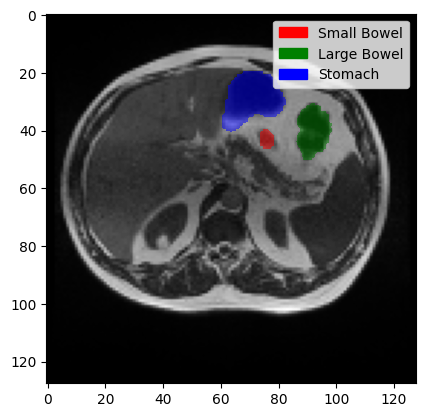

In [ ]:
# Assuming X and y are loaded as mentioned
X, y = train_generator_class.__getitem__(9)

plot_masks(X, y)

In [ ]:
train_loader = DataLoader(train_generator_class, batch_size=32, num_workers=0)
val_loader = DataLoader(val_generator_class, batch_size=32, num_workers=0)
test_loader = DataLoader(test_generator_class, batch_size=32, num_workers=0)

In [ ]:
print("Batch size:", train_loader.batch_size)
print("Num workers:", train_loader.num_workers)
print("Dataset size:", len(train_loader.dataset))
print("Number of batches:", len(train_loader))

Batch size: 32
Num workers: 0
Dataset size: 10783
Number of batches: 337


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [ ]:
model = SimpleUNet()
input = torch.randn(1, 3, 128, 128)  # Example input
output = model(input)
print(output.shape)  # Should be torch.Size([1, 3, 128, 128])

torch.Size([1, 3, 128, 128])


In [ ]:
model = SimpleUNet().to(device)  # Ensure your model is defined or loaded

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.2, patience=5, verbose=True, min_lr=0.001)

# Criterion
from src.loss import DiceLoss
criterion = DiceLoss().to(device)
# dice_loss = DiceLoss(to_onehot_y=False, softmax=True)

iou_criterion = IoU().to(device)

In [ ]:
# Training and validation loops
train_losses = []
train_iou_0 = [] # small bowel
train_iou_1 = [] # large bowel
train_iou_2 = [] # stomach

val_losses = []
val_iou_0 = []
val_iou_1 = []
val_iou_2 = []

epochs = 10

for epoch in range(epochs):
    model.train()
    train_loss_meter = AverageMeter()
    iou_meter_0 = AverageMeter()
    iou_meter_1 = AverageMeter()
    iou_meter_2 = AverageMeter()

    for data, target in tqdm(train_loader, desc=f'Epoch {epoch} Training'):
        data, target = data.to(device), target.to(device)
        data = data.permute(0, 3, 1, 2)
        target = target.permute(0, 3, 1, 2)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        # loss = dice_loss(output, target)
        loss.backward()
        optimizer.step()

        train_loss_meter.update(loss.item(), data.size(0))
        iou_0, iou_1, iou_2 = iou_criterion(output, target)
        iou_meter_0.update(iou_0.item(), data.size(0))
        iou_meter_1.update(iou_1.item(), data.size(0))
        iou_meter_2.update(iou_2.item(), data.size(0))

    train_losses.append(train_loss_meter.avg)
    train_iou_0.append(iou_meter_0.avg)
    train_iou_1.append(iou_meter_1.avg)
    train_iou_2.append(iou_meter_2.avg)

    # Validation phase
    model.eval()
    val_loss_meter = AverageMeter()
    val_iou_meter_0 = AverageMeter()
    val_iou_meter_1 = AverageMeter()
    val_iou_meter_2 = AverageMeter()

    with torch.no_grad():
        for data, target in tqdm(val_loader, desc=f'Epoch {epoch} Validation'):
            data, target = data.to(device), target.to(device)
            data = data.permute(0, 3, 1, 2)
            target = target.permute(0, 3, 1, 2)
            output = model(data)
            loss = criterion(output, target)
            # loss = dice_loss(output, target)

            val_loss_meter.update(loss.item(), data.size(0))
            iou_0, iou_1, iou_2 = iou_criterion(output, target)
            val_iou_meter_0.update(iou_0.item(), data.size(0))
            val_iou_meter_1.update(iou_1.item(), data.size(0))
            val_iou_meter_2.update(iou_2.item(), data.size(0))

    val_losses.append(val_loss_meter.avg)
    val_iou_0.append(val_iou_meter_0.avg)
    val_iou_1.append(val_iou_meter_1.avg)
    val_iou_2.append(val_iou_meter_2.avg)

    scheduler.step(val_loss_meter.avg)
    print(f'Epoch {epoch}: Train Loss: {train_loss_meter.avg:.4f}, Val Loss: {val_loss_meter.avg:.4f}, \n \
            Train IOU SB: {iou_meter_0.avg:.4f}, Val IOU SB: {val_iou_meter_0.avg:.4f}, \n \
            Train IOU LB: {iou_meter_1.avg:.4f}, Val IOU LB: {val_iou_meter_1.avg:.4f}, \n \
            Train IOU S: {iou_meter_2.avg:.4f}, Val IOU S: {val_iou_meter_2.avg:.4f}')
    # Save model checkpoint
    torch.save(model.state_dict(), f'small_UNET_model_epoch_{epoch}.pth')


Epoch 0 Validation: 100%|██████████| 78/78 [00:22<00:00,  3.41it/s]


Epoch 0: Train Loss: 0.5722, Val Loss: 0.5027, 
             Train IOU SB: 0.2074, Val IOU SB: 0.1728, 
             Train IOU LB: 0.2276, Val IOU LB: 0.2512, 
             Train IOU S: 0.2408, Val IOU S: 0.3044


Epoch 1 Validation: 100%|██████████| 78/78 [00:23<00:00,  3.26it/s]


Epoch 1: Train Loss: 0.4272, Val Loss: 0.4322, 
             Train IOU SB: 0.1469, Val IOU SB: 0.1691, 
             Train IOU LB: 0.3315, Val IOU LB: 0.3042, 
             Train IOU S: 0.3268, Val IOU S: 0.3241


Epoch 2 Validation: 100%|██████████| 78/78 [00:21<00:00,  3.56it/s]


Epoch 2: Train Loss: 0.3630, Val Loss: 0.3515, 
             Train IOU SB: 0.1423, Val IOU SB: 0.1637, 
             Train IOU LB: 0.3786, Val IOU LB: 0.3627, 
             Train IOU S: 0.3641, Val IOU S: 0.3795


Epoch 3 Validation: 100%|██████████| 78/78 [00:23<00:00,  3.38it/s]


Epoch 3: Train Loss: 0.3018, Val Loss: 0.3299, 
             Train IOU SB: 0.1546, Val IOU SB: 0.1837, 
             Train IOU LB: 0.4224, Val IOU LB: 0.4016, 
             Train IOU S: 0.3935, Val IOU S: 0.3731


Epoch 4 Validation: 100%|██████████| 78/78 [00:22<00:00,  3.52it/s]


Epoch 4: Train Loss: 0.2385, Val Loss: 0.2751, 
             Train IOU SB: 0.1869, Val IOU SB: 0.2347, 
             Train IOU LB: 0.4603, Val IOU LB: 0.4473, 
             Train IOU S: 0.4148, Val IOU S: 0.3840


Epoch 5 Validation: 100%|██████████| 78/78 [00:22<00:00,  3.39it/s]


Epoch 5: Train Loss: 0.1929, Val Loss: 0.2206, 
             Train IOU SB: 0.2208, Val IOU SB: 0.2643, 
             Train IOU LB: 0.4907, Val IOU LB: 0.5023, 
             Train IOU S: 0.4320, Val IOU S: 0.4199


Epoch 6 Validation: 100%|██████████| 78/78 [00:22<00:00,  3.53it/s]


Epoch 6: Train Loss: 0.1616, Val Loss: 0.1827, 
             Train IOU SB: 0.2520, Val IOU SB: 0.2653, 
             Train IOU LB: 0.5116, Val IOU LB: 0.5362, 
             Train IOU S: 0.4550, Val IOU S: 0.4592


Epoch 7 Validation: 100%|██████████| 78/78 [00:22<00:00,  3.52it/s]


Epoch 7: Train Loss: 0.1338, Val Loss: 0.1607, 
             Train IOU SB: 0.2764, Val IOU SB: 0.2436, 
             Train IOU LB: 0.5334, Val IOU LB: 0.5527, 
             Train IOU S: 0.4783, Val IOU S: 0.4855


Epoch 8 Validation: 100%|██████████| 78/78 [00:23<00:00,  3.36it/s]


Epoch 8: Train Loss: 0.1153, Val Loss: 0.1394, 
             Train IOU SB: 0.2901, Val IOU SB: 0.2539, 
             Train IOU LB: 0.5479, Val IOU LB: 0.5696, 
             Train IOU S: 0.4987, Val IOU S: 0.5095


Epoch 9 Validation: 100%|██████████| 78/78 [00:22<00:00,  3.52it/s]


Epoch 9: Train Loss: 0.0960, Val Loss: 0.1481, 
             Train IOU SB: 0.3078, Val IOU SB: 0.2487, 
             Train IOU LB: 0.5644, Val IOU LB: 0.5730, 
             Train IOU S: 0.5125, Val IOU S: 0.4976


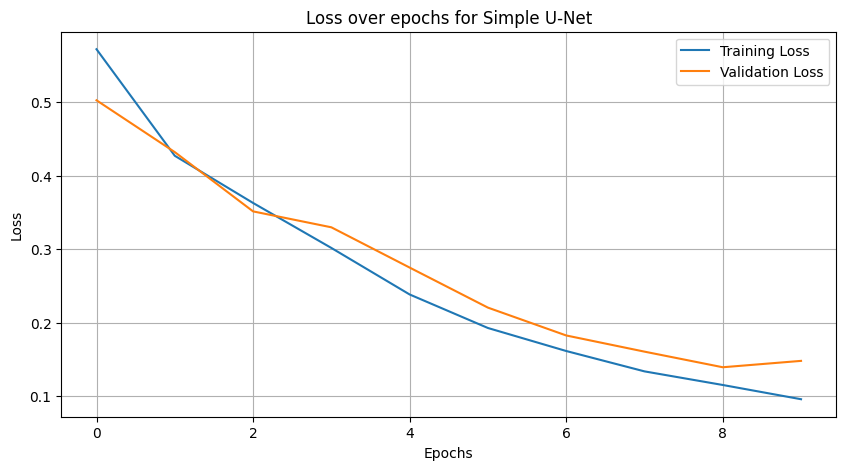

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss over epochs for Simple U-Net')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
model = SimpleUNet().to(device)

# Load the saved model weights
model.load_state_dict(torch.load('small_UNET_model_epoch_8.pth'))

# Set the model to evaluation mode if you are making predictions
model.eval()

SimpleUNet(
  (inc): ConvBlock(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (norm1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (relu1): LeakyReLU(negative_slope=0.1)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (norm2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (relu2): LeakyReLU(negative_slope=0.1)
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): ConvBlock(
        (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (norm1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (relu1): LeakyReLU(negative_slope=0.1)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (norm2): InstanceNorm2d(128, eps=1e-05, m

In [ ]:
images_test = []
predictions = []
masks = []

test_iou_meter_0 = AverageMeter()
test_iou_meter_1 = AverageMeter()
test_iou_meter_2 = AverageMeter()
test_dice_loss_meter = AverageMeter()

# No need to track gradients here
with torch.no_grad():
    for data, target in tqdm(test_loader):
        # Assuming your DataLoader returns a tuple of (images, labels)

        images = data.permute(0, 3, 1, 2).to(device)
        images_test.append(images)

        # print(images.shape)
        # Generate predictions
        output = model(images)
        predictions.append(output)
        # print(output.shape)

        mask = target.permute(0, 3, 1, 2).to(device)
        masks.append(mask)
        # print(mask.shape)

        dice_loss = criterion(output, mask)
        iou_value0, iou_value1, iou_value2 = iou_criterion(output, mask)

        test_dice_loss_meter.update(dice_loss.item(), output.size(0))
        test_iou_meter_0.update(iou_value0.item(), output.size(0))
        test_iou_meter_1.update(iou_value1.item(), output.size(0))
        test_iou_meter_2.update(iou_value2.item(), output.size(0))


print(f'Test Dice Loss: {test_dice_loss_meter.avg:.4f}, \n \
        IOU for SB: {test_iou_meter_0.avg: .4f}, \n \
        IOU for LB: {test_iou_meter_1.avg: .4f}, \n \
        IOU for S: {test_iou_meter_2.avg: .4f}')

100%|██████████| 104/104 [00:30<00:00,  3.36it/s]

Test Dice Loss: 0.1254, 
         IOU for SB:  0.2590, 
         IOU for LB:  0.5782, 
         IOU for S:  0.5055


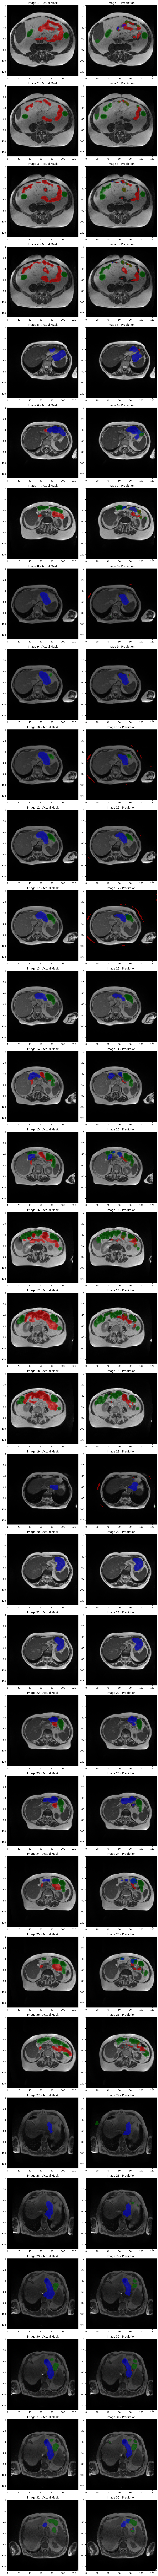

In [ ]:
img_s = images_test[1]
pred_s = predictions[1]
mask_s = masks[1]

display_comparison(img_s.cpu().numpy(), pred_s.cpu().numpy(), mask_s.cpu().numpy())

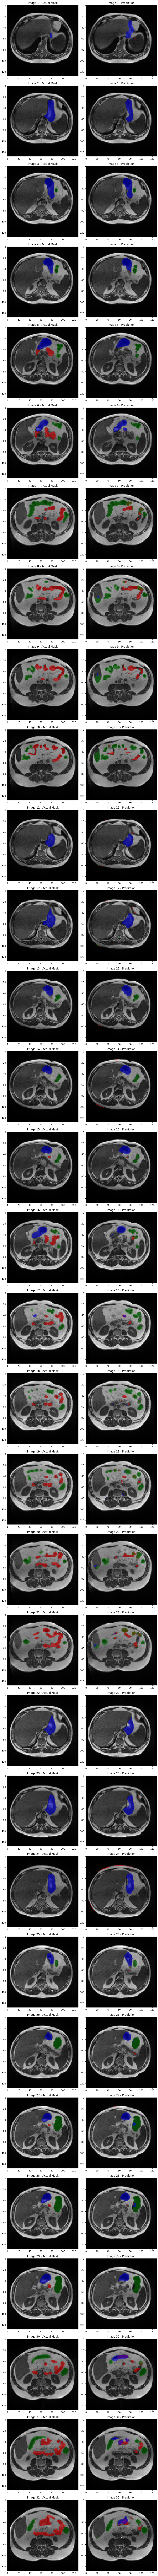

In [ ]:
img_s = images_test[0]
pred_s = predictions[0]
mask_s = masks[0]

display_comparison(img_s.cpu().numpy(), pred_s.cpu().numpy(), mask_s.cpu().numpy())